In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error






plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# makes plots bigger
plt.rcParams["figure.figsize"] = (20,8)

In [2]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [3]:
df = pd.read_csv('GREATEC.csv')

df= df[['c','d','h','l','o','v']]

df.info()

df['d'] = pd.to_datetime(df['d'], dayfirst= True )

df.set_index('d',inplace=True,drop=True)

df.index.name = None

df

data = df.iloc[-200:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c       398 non-null    float64
 1   d       398 non-null    object 
 2   h       398 non-null    float64
 3   l       398 non-null    float64
 4   o       398 non-null    float64
 5   v       398 non-null    float64
dtypes: float64(5), object(1)
memory usage: 18.8+ KB


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.2f, predicted=%.2f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [5]:
data_G = series_to_supervised(data[['c']], n_in=1,n_out=1)

In [6]:
data_G

array([[1.035, 1.175],
       [1.175, 1.12 ],
       [1.12 , 1.15 ],
       [1.15 , 1.105],
       [1.105, 1.14 ],
       [1.14 , 1.19 ],
       [1.19 , 1.145],
       [1.145, 1.175],
       [1.175, 1.14 ],
       [1.14 , 1.14 ],
       [1.14 , 1.25 ],
       [1.25 , 1.29 ],
       [1.29 , 1.305],
       [1.305, 1.355],
       [1.355, 1.375],
       [1.375, 1.34 ],
       [1.34 , 1.38 ],
       [1.38 , 1.375],
       [1.375, 1.36 ],
       [1.36 , 1.39 ],
       [1.39 , 1.365],
       [1.365, 1.425],
       [1.425, 1.43 ],
       [1.43 , 1.405],
       [1.405, 1.415],
       [1.415, 1.425],
       [1.425, 1.425],
       [1.425, 1.445],
       [1.445, 1.425],
       [1.425, 1.39 ],
       [1.39 , 1.385],
       [1.385, 1.36 ],
       [1.36 , 1.425],
       [1.425, 1.515],
       [1.515, 1.47 ],
       [1.47 , 1.45 ],
       [1.45 , 1.48 ],
       [1.48 , 1.57 ],
       [1.57 , 1.635],
       [1.635, 1.675],
       [1.675, 1.64 ],
       [1.64 , 1.7  ],
       [1.7  , 1.69 ],
       [1.6

In [7]:
mae, y, yhat = walk_forward_validation(data_G , 12)

>expected=4.85, predicted=4.62
>expected=4.73, predicted=4.76
>expected=4.85, predicted=4.77
>expected=4.80, predicted=4.76
>expected=4.75, predicted=4.77
>expected=4.97, predicted=4.83
>expected=5.18, predicted=4.77
>expected=5.66, predicted=5.03
>expected=5.71, predicted=5.43
>expected=5.85, predicted=5.61
>expected=5.75, predicted=5.76
>expected=5.79, predicted=5.79


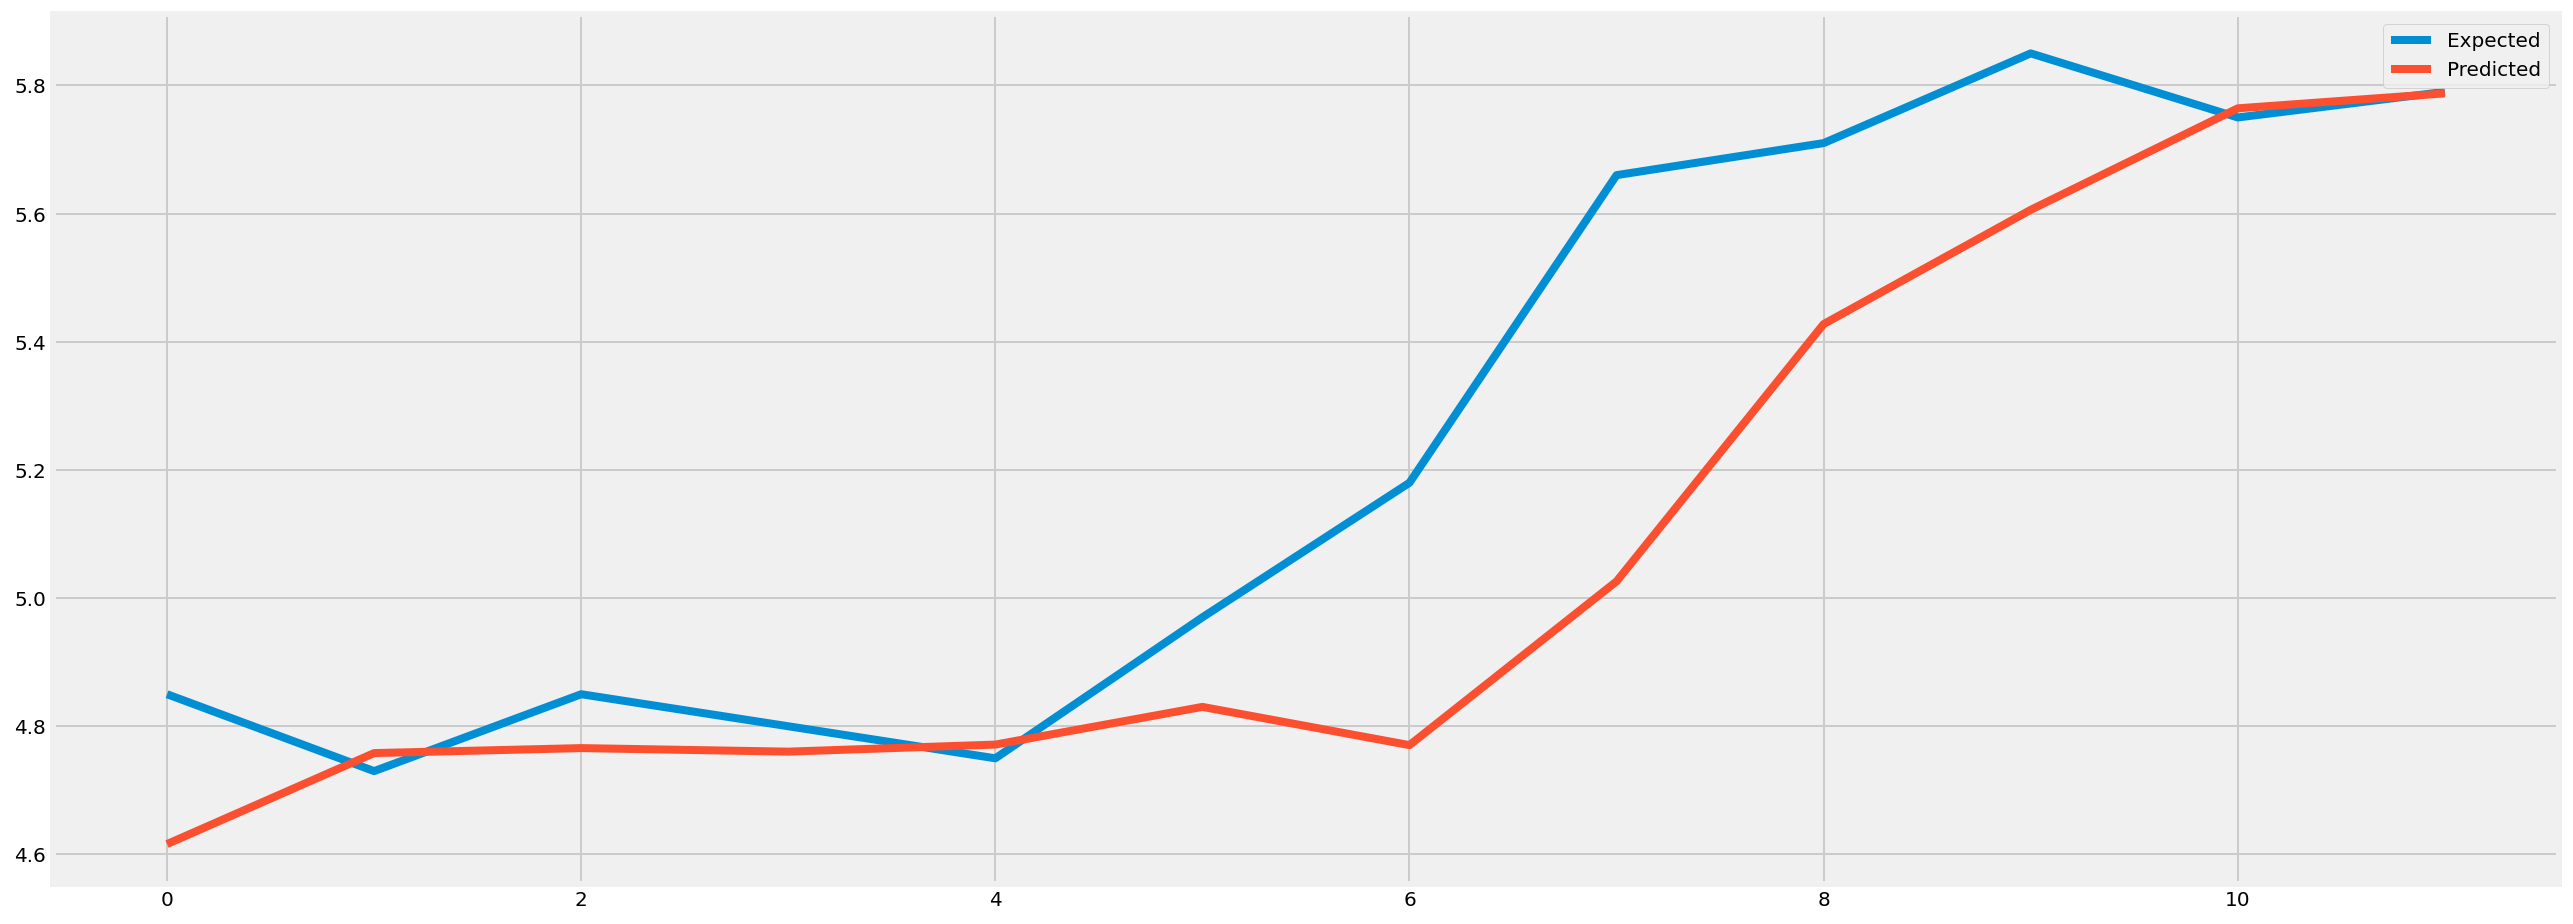

In [8]:
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [9]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    mape_1 = np.mean(np.abs((actual - forecast) / actual)) * 100# MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
   
    return({'mape':mape, 'mape_1':mape_1, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

In [10]:
forecast_accuracy(yhat, y)

{'mape': 0.03312633034856926,
 'mape_1': 3.3126330348569257,
 'me': -0.16715590277777478,
 'mae': 0.17778748611111572,
 'mpe': -0.030970931501924637,
 'rmse': 0.25709151246579887,
 'corr': 0.9008578787301152}

In [11]:
data_latest = data[['c']].values

In [25]:
train = series_to_supervised(data_latest, n_in=1,n_out=1)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = data_latest[-1:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [5.79], Predicted: 5.776


In [29]:
train

array([[1.035, 1.175],
       [1.175, 1.12 ],
       [1.12 , 1.15 ],
       [1.15 , 1.105],
       [1.105, 1.14 ],
       [1.14 , 1.19 ],
       [1.19 , 1.145],
       [1.145, 1.175],
       [1.175, 1.14 ],
       [1.14 , 1.14 ],
       [1.14 , 1.25 ],
       [1.25 , 1.29 ],
       [1.29 , 1.305],
       [1.305, 1.355],
       [1.355, 1.375],
       [1.375, 1.34 ],
       [1.34 , 1.38 ],
       [1.38 , 1.375],
       [1.375, 1.36 ],
       [1.36 , 1.39 ],
       [1.39 , 1.365],
       [1.365, 1.425],
       [1.425, 1.43 ],
       [1.43 , 1.405],
       [1.405, 1.415],
       [1.415, 1.425],
       [1.425, 1.425],
       [1.425, 1.445],
       [1.445, 1.425],
       [1.425, 1.39 ],
       [1.39 , 1.385],
       [1.385, 1.36 ],
       [1.36 , 1.425],
       [1.425, 1.515],
       [1.515, 1.47 ],
       [1.47 , 1.45 ],
       [1.45 , 1.48 ],
       [1.48 , 1.57 ],
       [1.57 , 1.635],
       [1.635, 1.675],
       [1.675, 1.64 ],
       [1.64 , 1.7  ],
       [1.7  , 1.69 ],
       [1.6

In [26]:
trainX

array([[1.035],
       [1.175],
       [1.12 ],
       [1.15 ],
       [1.105],
       [1.14 ],
       [1.19 ],
       [1.145],
       [1.175],
       [1.14 ],
       [1.14 ],
       [1.25 ],
       [1.29 ],
       [1.305],
       [1.355],
       [1.375],
       [1.34 ],
       [1.38 ],
       [1.375],
       [1.36 ],
       [1.39 ],
       [1.365],
       [1.425],
       [1.43 ],
       [1.405],
       [1.415],
       [1.425],
       [1.425],
       [1.445],
       [1.425],
       [1.39 ],
       [1.385],
       [1.36 ],
       [1.425],
       [1.515],
       [1.47 ],
       [1.45 ],
       [1.48 ],
       [1.57 ],
       [1.635],
       [1.675],
       [1.64 ],
       [1.7  ],
       [1.69 ],
       [1.675],
       [1.68 ],
       [1.86 ],
       [1.85 ],
       [1.81 ],
       [1.74 ],
       [1.9  ],
       [1.99 ],
       [1.985],
       [2.025],
       [1.96 ],
       [1.96 ],
       [1.975],
       [1.91 ],
       [1.915],
       [1.93 ],
       [1.935],
       [2.02 ],
       [

In [27]:
trainy

array([1.175, 1.12 , 1.15 , 1.105, 1.14 , 1.19 , 1.145, 1.175, 1.14 ,
       1.14 , 1.25 , 1.29 , 1.305, 1.355, 1.375, 1.34 , 1.38 , 1.375,
       1.36 , 1.39 , 1.365, 1.425, 1.43 , 1.405, 1.415, 1.425, 1.425,
       1.445, 1.425, 1.39 , 1.385, 1.36 , 1.425, 1.515, 1.47 , 1.45 ,
       1.48 , 1.57 , 1.635, 1.675, 1.64 , 1.7  , 1.69 , 1.675, 1.68 ,
       1.86 , 1.85 , 1.81 , 1.74 , 1.9  , 1.99 , 1.985, 2.025, 1.96 ,
       1.96 , 1.975, 1.91 , 1.915, 1.93 , 1.935, 2.02 , 2.14 , 2.28 ,
       2.41 , 2.38 , 2.395, 2.385, 2.335, 2.4  , 2.325, 2.34 , 2.28 ,
       2.325, 2.295, 2.69 , 2.8  , 2.695, 2.69 , 2.71 , 2.76 , 2.71 ,
       2.7  , 2.825, 2.795, 2.9  , 2.89 , 2.805, 3.05 , 3.045, 3.195,
       3.19 , 3.105, 3.055, 3.125, 3.155, 3.18 , 3.155, 3.29 , 3.335,
       3.395, 3.375, 3.435, 3.52 , 3.45 , 3.41 , 3.275, 3.15 , 3.075,
       2.905, 3.   , 3.08 , 3.065, 2.99 , 3.075, 2.935, 2.96 , 3.01 ,
       3.   , 3.15 , 3.26 , 3.27 , 3.395, 3.46 , 3.34 , 3.475, 3.435,
       3.415, 3.39 ,

In [28]:
row

array([5.79])

In [14]:
#data = df.iloc[-200:]